# Урок 2. Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

**Домашнее задание**

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

3. Повторить п.2, но используя уже не медиану, а max

4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

**Ссылки**
http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

In [1]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath

import re
import numpy as np
from nltk.corpus import stopwords
from razdel import tokenize 
import pymorphy2  
import nltk

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report
from sklearn.metrics import precision_recall_curve, confusion_matrix
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

D:\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Загрузим, новости, пользователей и списки последних прочитанных новостей

In [2]:
news = pd.read_csv("articles.csv")
users = pd.read_csv("users_articles.csv")

display(news.head(3), users.head(3))

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Получаем векторные представления новостей

In [3]:
stopword_ru = nltk.corpus.stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [4]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [5]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [6]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-5-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 28.5 s


In [7]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 4min 29s


In [8]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [9]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [10]:
print([common_dictionary[i] for i in range(9, 13)])

['борьба', 'ватутин', 'взаимодействие', 'власть']


**Обучение**

In [11]:
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [12]:
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [13]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.103904836),
 (11, 0.21338397),
 (12, 0.09405202),
 (13, 0.08135801),
 (24, 0.48925427)]

In [14]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год это который россия компания свой новый
topic_1: производитель одежда употребление надпись сосредоточить выпуск забастовка
topic_2: млн рубль год доход составить сумма компания
topic_3: год который это человек ребёнок мочь первый
topic_4: журнал последствие свет дыра содержать температура прогноз
topic_5: гражданин россиянин правительство фронт мероприятие проект народный
topic_6: это год мочь россия российский который исследование
topic_7: это который также человек решение глава вопрос
topic_8: рекомендовать собственность отряд фаза специальный индия гарантия
topic_9: банк nn взрыв аэропорт сотрудник активность доклад
topic_10: район погибнуть статья пострадать авария город автомобиль
topic_11: остров палата последствие негативно нервный макаров ухо
topic_12: космос лёд снежный понятие выводить вследствие корь
topic_13: статья полицейский задержать продукция подросток сотрудник египетский
topic_14: фонд научный миссия пациент больной кожа финансы
topic_15: это который укра

Функция, которая будет возвращать векторное представление новости

In [15]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [16]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.095326,0.0,0.0,0.010558,0.0,0.0,0.0,0.095114,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.033166,0.000000,0.0,0.000000,0.045514
1,4896,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.053125,0.292555
2,4897,0.000000,0.0,0.0,0.103946,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.489256
3,4898,0.000000,0.0,0.0,0.028734,0.0,0.0,0.0,0.000000,0.0,...,0.474015,0.0,0.0,0.0,0.0,0.072011,0.057697,0.0,0.000000,0.327467
4,4899,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.130120,0.0,...,0.689048,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000


получили вектора наших новостей

**Векторные представления пользователей**

In [17]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [18]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [19]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.15107296, 0.        ,
       0.        , 0.2197587 , 0.24028602, 0.        , 0.        ,
       0.        , 0.        , 0.0609759 , 0.        , 0.        ,
       0.        , 0.        , 0.09135875, 0.        , 0.        ,
       0.09568403, 0.        , 0.        , 0.        , 0.12993775])

In [20]:
user_articles_list = users['articles'].iloc[33]
display(user_articles_list, 
        eval(user_articles_list)
       )

'[323329, 321961, 324743, 323186, 324632, 474690]'

[323329, 321961, 324743, 323186, 324632, 474690]

In [21]:
def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [22]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.174546,0.0,0.019379,0.106216,0.000000,0.021519,0.090993,0.154132,0.000000,...,0.082257,0.0,0.063104,0.040673,0.0,0.126889,0.000000,0.011739,0.002940,0.021656
1,u108690,0.168132,0.0,0.011904,0.095679,0.002239,0.021595,0.158818,0.111617,0.004465,...,0.211154,0.0,0.030523,0.005425,0.0,0.000000,0.003050,0.024692,0.017263,0.023758
2,u108339,0.184965,0.0,0.006350,0.144207,0.013569,0.045677,0.092810,0.139158,0.008767,...,0.066117,0.0,0.070804,0.021712,0.0,0.003798,0.028958,0.011116,0.023687,0.006645


In [23]:
get_user_embedding_mean(user_articles_list)

array([0.22866811, 0.        , 0.01318085, 0.15224576, 0.00274399,
       0.02720166, 0.2316159 , 0.08998502, 0.00323787, 0.03684798,
       0.00399259, 0.        , 0.00191571, 0.00234838, 0.        ,
       0.04799771, 0.        , 0.02202448, 0.02232838, 0.        ,
       0.01010994, 0.02841332, 0.02628601, 0.0322067 , 0.00238187])

In [24]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.174546,0.0,0.019379,0.106216,0.000000,0.021519,0.090993,0.154132,0.000000,...,0.082257,0.0,0.063104,0.040673,0.0,0.126889,0.000000,0.011739,0.002940,0.021656
1,u108690,0.168132,0.0,0.011904,0.095679,0.002239,0.021595,0.158818,0.111617,0.004465,...,0.211154,0.0,0.030523,0.005425,0.0,0.000000,0.003050,0.024692,0.017263,0.023758
2,u108339,0.184965,0.0,0.006350,0.144207,0.013569,0.045677,0.092810,0.139158,0.008767,...,0.066117,0.0,0.070804,0.021712,0.0,0.003798,0.028958,0.011116,0.023687,0.006645


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [25]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [26]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.174546,0.0,0.019379,0.106216,0.000000,0.021519,0.090993,0.154132,0.000000,...,0.0,0.063104,0.040673,0.0,0.126889,0.000000,0.011739,0.002940,0.021656,0
1,u108690,0.168132,0.0,0.011904,0.095679,0.002239,0.021595,0.158818,0.111617,0.004465,...,0.0,0.030523,0.005425,0.0,0.000000,0.003050,0.024692,0.017263,0.023758,1
2,u108339,0.184965,0.0,0.006350,0.144207,0.013569,0.045677,0.092810,0.139158,0.008767,...,0.0,0.070804,0.021712,0.0,0.003798,0.028958,0.011116,0.023687,0.006645,1


In [27]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [28]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [29]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.13993468, 0.03420795, 0.48590016, 0.21669739, 0.03044003,
       0.08188286, 0.09759605, 0.04920603, 0.10649562, 0.12126301])

**Метрики качества**

In [30]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.294916, F-Score=0.711, Precision=0.700, Recall=0.722


In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1679   76]
 [  69  176]]


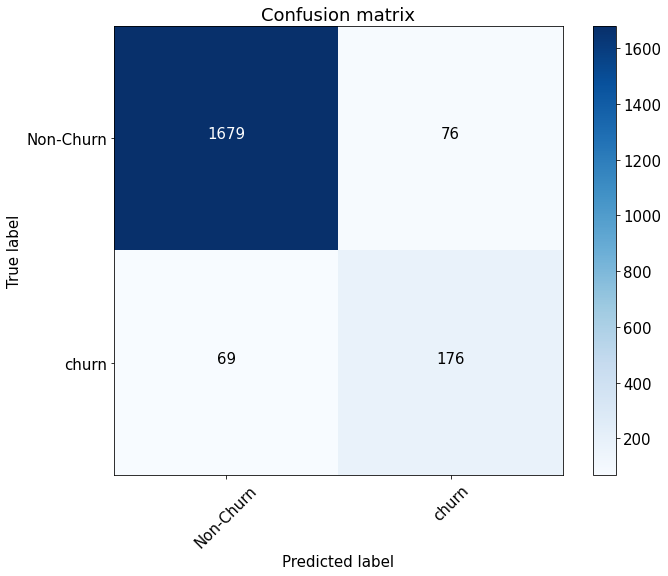

In [32]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [33]:
roc_auc_score(y_test, preds)

0.9530623873481016

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. 

In [34]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [35]:
get_user_embedding_median(user_articles_list)

array([0.21791732, 0.        , 0.        , 0.08504753, 0.        ,
       0.        , 0.21872699, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01341104, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02690718, 0.        , 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [36]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.129991,0.0,0.0,0.052095,0.000000,0.000000,0.066120,0.179839,0.000000,...,0.022926,0.0,0.042446,0.000000,0.0,0.047842,0.0,0.000000,0.000000,0.000000
1,u108690,0.115621,0.0,0.0,0.078227,0.000000,0.005001,0.175604,0.123502,0.000000,...,0.159652,0.0,0.014461,0.000000,0.0,0.000000,0.0,0.010449,0.000000,0.016415
2,u108339,0.184302,0.0,0.0,0.129394,0.007234,0.033760,0.065497,0.158637,0.007574,...,0.063235,0.0,0.074211,0.017258,0.0,0.000000,0.0,0.000000,0.006065,0.000000


In [37]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.129991,0.0,0.0,0.052095,0.000000,0.000000,0.066120,0.179839,0.000000,...,0.0,0.042446,0.000000,0.0,0.047842,0.0,0.000000,0.000000,0.000000,0
1,u108690,0.115621,0.0,0.0,0.078227,0.000000,0.005001,0.175604,0.123502,0.000000,...,0.0,0.014461,0.000000,0.0,0.000000,0.0,0.010449,0.000000,0.016415,1
2,u108339,0.184302,0.0,0.0,0.129394,0.007234,0.033760,0.065497,0.158637,0.007574,...,0.0,0.074211,0.017258,0.0,0.000000,0.0,0.000000,0.006065,0.000000,1


In [38]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [39]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [40]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.08437277, 0.01568853, 0.77135187, 0.20190057, 0.02747734,
       0.01681014, 0.03821027, 0.02482289, 0.22296338, 0.09713591])

**Метрики качества**

In [41]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.254181, F-Score=0.760, Precision=0.681, Recall=0.861


Confusion matrix, without normalization
[[1656   99]
 [  35  210]]


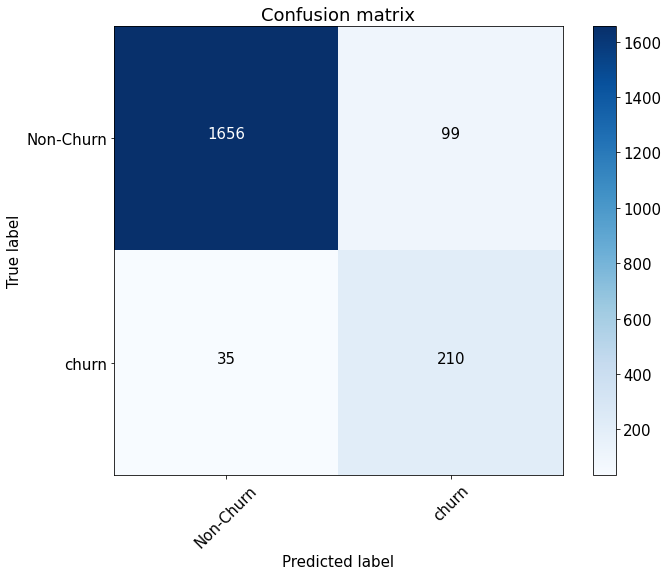

In [42]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [43]:
roc_auc_score(y_test, preds)

0.9699656956799814

3. Повторить п.2, но используя уже не медиану, а max

In [44]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [45]:
get_user_embedding_max(user_articles_list)

array([0.52876562, 0.        , 0.05424612, 0.40998787, 0.01646396,
       0.12287727, 0.4630987 , 0.35643777, 0.01942723, 0.21004015,
       0.02395555, 0.        , 0.01149426, 0.01409026, 0.        ,
       0.18243228, 0.        , 0.07529997, 0.13397028, 0.        ,
       0.03362415, 0.17047991, 0.05432327, 0.19324018, 0.01429121])

In [46]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.454276,0.0,0.116273,0.382035,0.000000,0.064712,0.219759,0.240286,0.000000,...,0.369211,0.0,0.202374,0.147482,0.0,0.434859,0.000000,0.070433,0.017641,0.129938
1,u108690,0.344549,0.0,0.047932,0.309381,0.013434,0.100067,0.246060,0.167710,0.026792,...,0.390414,0.0,0.129791,0.021647,0.0,0.000000,0.018301,0.096891,0.092495,0.074889
2,u108339,0.343362,0.0,0.038102,0.275090,0.048698,0.142810,0.219341,0.242488,0.021743,...,0.138585,0.0,0.159378,0.053922,0.0,0.022789,0.145757,0.066698,0.071261,0.021211


In [47]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.454276,0.0,0.116273,0.382035,0.000000,0.064712,0.219759,0.240286,0.000000,...,0.0,0.202374,0.147482,0.0,0.434859,0.000000,0.070433,0.017641,0.129938,0
1,u108690,0.344549,0.0,0.047932,0.309381,0.013434,0.100067,0.246060,0.167710,0.026792,...,0.0,0.129791,0.021647,0.0,0.000000,0.018301,0.096891,0.092495,0.074889,1
2,u108339,0.343362,0.0,0.038102,0.275090,0.048698,0.142810,0.219341,0.242488,0.021743,...,0.0,0.159378,0.053922,0.0,0.022789,0.145757,0.066698,0.071261,0.021211,1


In [48]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [49]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [50]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.02676179, 0.00250516, 0.8460147 , 0.21000361, 0.00728404,
       0.00196227, 0.01305578, 0.00737414, 0.03719969, 0.42445561])

**Метрики качества**

In [51]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.374589, F-Score=0.815, Precision=0.831, Recall=0.800


Confusion matrix, without normalization
[[1715   40]
 [  50  195]]


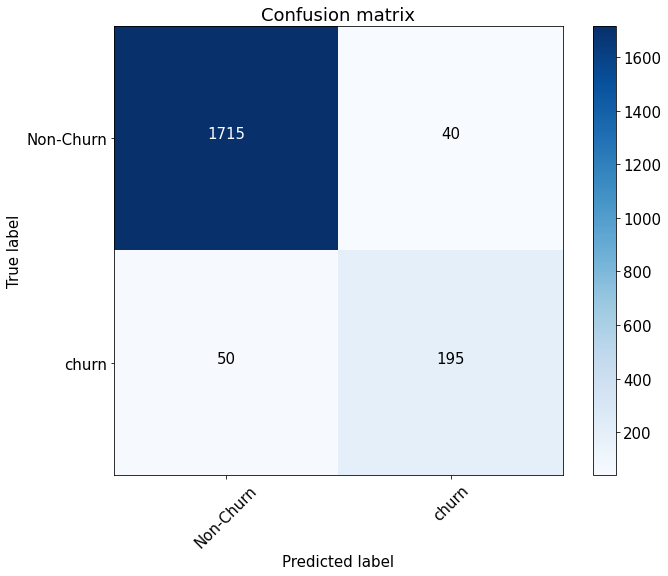

In [52]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [53]:
roc_auc_score(y_test, preds)

0.9774358974358973

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [54]:
def score_with_user_embedding(func):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: func(x), 1)])
    user_embeddings.columns = [f'topic_{i}' for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid'] + [f'topic_{i}' for i in range(25)]]

    X = pd.merge(user_embeddings, target, 'left')

    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(
    X[[f'topic_{i}' for i in range(25)]], X['churn'], random_state=0)
    
    logreg = LogisticRegression()

    #обучим наш пайплайн
    logreg.fit(X_train, y_train)

    #наши прогнозы для тестовой выборки
    preds = logreg.predict_proba(X_test)[:, 1]

    # Рассчитаем Precision, Recall, F_score, roc_auc_score
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    roc_auc_score = roc_auc_score(y_test, preds)

    return round(thresholds[ix], 4), round(fscore[ix], 4), round(precision[ix], 4), round(recall[ix], 4), round(roc_auc_score, 4)

In [55]:
results = pd.DataFrame(np.array([
    score_with_user_embedding(func=get_user_embedding_mean),
    score_with_user_embedding(func=get_user_embedding_median),
    score_with_user_embedding(func=get_user_embedding_max)
]), columns=['Best Threshold', 'F-Score', 'Precision', 'Recall', 'ROC AUC score'])

results['func'] = ['mean', 'median', 'max']
results = results.set_index('func')

In [56]:
results

,Best Threshold,F-Score,Precision,Recall,ROC AUC score
func,,,,,
mean,0.2949,0.7108,0.6996,0.7224,0.9531
median,0.2542,0.7604,0.6806,0.8612,0.9700
max,0.3746,0.8150,0.8305,0.8000,0.9774


6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных
В данном случае наилучшие результаты для получения эмбедингов пользователей по всем метрикам качества показал метод max.  Использование максимума позволяет получить болие точные результаты, поскольку разброс в темах становится меньше, темы получаются более узко-направленными. При этом методе пики распределения не размываются. В данной базе встречающиеся слова очень разнообразны.